# Geospatial Image Classification with Deep Learning  
## End‑to‑End Satellite Image Analysis using CNNs and Vision Transformers

## Table of Contents

1. [The Dataset](#The-Dataset)

2. [Importing The Required Libraries and Data](#Importing-The-Required-Libraries-and-Data)
    - [TensorFlow Environment Settings](#TensorFlow-Environment-Settings)
    - [The Required Libraries](#The-Required-Libraries)
    - [Set Random Seed for Reproducibility](#Set-Random-Seed-for-Reproducibility)
    - [Check GPU Availability](#Check-GPU-Availability)
    - [Define Data Folder Path](#Define-Data-Folder-Path)

3. [Model Hyperparameters](#Model-Hyperparameters)

4. [Create Image Data Generator for Data Augmentation](#Create-Image-Data-Generator-for-Data-Augmentation)

5. [Create Training and Validation Generators](#Create-Training-and-Validation-Generators)

6. [Model Definition](#Model-Definition)

7. [Model Compilation](#Model-Compilation)

8. [Model Training](#Model-Training)

9. []

## The Dataset

The dataset contains 6,000 color satellite images, each resized to 64×64 pixels and labeled for a binary land‑use classification task. Every image belongs to one of two categories:

- ``class_0_non_agri``: regions without agricultural activity (e.g., forests, urban regions, water bodies, barren land).

- ``class_1_agri``: areas showing agricultural structures such as crop fields or structured farmland.

The images are evenly distributed across both classes and exhibit natural variability in geographic context. This diversity helps the model generalize to different environmental conditions and reduces overfitting to specific visual patterns.

All images are RGB and share the same spatial resolution and are preprocessed into a consistent format suitable for convolutional neural networks. The dataset provides a solid foundation for training and evaluating models aimed at automated agricultural land‑use detection.

## Importing The Required Libraries and Data

### TensorFlow Environment Settings

> Environment Variables:

- `TF_ENABLE_ONEDNN_OPTS` \
Controls Intel oneDNN CPU optimizations in TensorFlow.
  - `1` → enable optimized CPU kernels (default, faster)
  - `0` → disable them (useful for reproducibility or avoiding numerical differences)

- `TF_CPP_MIN_LOG_LEVEL` \
Controls how much TensorFlow logs to the console.
  - `0` → show all logs  
  - `1` → hide INFO  
  - `2` → hide INFO + WARNING  
  - `3` → show only errors  


Environment variables must be set before TensorFlow loads, otherwise they have no effect. This ensures TensorFlow reads those settings during initialization.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

### The Required Libraries

In [2]:
import json
import sys
import time
import shutil
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dense, Dropout,
    BatchNormalization, GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix
)

### Set Random Seed for Reproducibility  

In [4]:
SEED = 62
random.seed(SEED) 
np.random.seed(SEED) 
tf.random.set_seed(SEED)

### Check GPU Availability

In [5]:
gpu_list = tf.config.list_physical_devices('GPU')
device = "gpu" if gpu_list else "cpu"

print("Device available for training:", device)

Device available for training: cpu


### Define Data Folder Path

In [6]:
data_path = os.path.join(".", "data") 
print("Data folder path:", data_path)

Data folder path: .\data


## Model Hyperparameters

Use a batch size that evenly divides both the number of validation samples and the number of training samples to prevent partial batches.



In [7]:
# Model hyperparameters
img_w, img_h = 64, 64
n_channels = 3      # Number of image channels (3 for RGB)

batch_size = 120
lr = 1e-3           # Learning rate
n_epochs = 20       # Number of epochs

model_name = "tf_model"

## Configure Image Data Generator for Data Augmentation

In [8]:
datagen = ImageDataGenerator(
    # Convert pixel values from the range [0,255] to [0,1]
    rescale= 1./255,
    # Randomly rotate images by up to ±25 degrees 
    rotation_range= 25, 
    # Randomly shift the image horizontally by up to 15% of the width
    width_shift_range= 0.2, 
    height_shift_range= 0.2, 
    # Apply a shearing transformation, like slanting the image
    shear_range= 0.2,
    # Randomly zoom in or out by up to 20%
    zoom_range= 0.2, 
    # Randomly flip images left–right
    horizontal_flip= True, 
    vertical_flip= True,
    # Determine how to fill in new pixels created by rotations, shifts, or zooms
    # "nearest" copies the value of the nearest pixel
    fill_mode= "nearest",
    validation_split= 0.2,
)

## Create Training and Validation Generators

In [9]:
train_generator = datagen.flow_from_directory(
    data_path,
    target_size= (img_w, img_h),
    batch_size= batch_size,
    class_mode= "binary",  # "categorical" for multi-class
    subset= "training",
    shuffle= True,
    seed= SEED,
)

val_generator = datagen.flow_from_directory(
    data_path,
    target_size= (img_w, img_h),
    batch_size= batch_size,
    class_mode= "binary",  # "categorical" for multi-class
    subset= "validation",
    shuffle= False,
    seed= SEED,
)


Found 4800 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.


> Why ``shuffle=True`` for training but ``shuffle=False`` for validation

Shuffling is enabled for the training generator because the model should see 
the data in a different order in each epoch to improve generalization and to reduce overfitting, while the validation generator keeps ``shuffle=False`` so evaluation remains stable and deterministic. Even with a fixed seed, shuffling the validation set is still discouraged because the goal of validation is stable, repeatable evaluation. A seed only guarantees that the shuffle order is the same each run, but the order would still change every epoch.

For ``flow_from_directory``, the default value of ``shuffle`` is ``True``.

## Model Definition

In [10]:
def build_cnn(input_shape, num_classes= 1):
    model = Sequential([
        # --- Convolution Block 1 ---
        Conv2D(32, 
               (5, 5), 
               activation= "relu", 
               padding= "same",
               strides= (1, 1), 
               kernel_initializer= HeUniform(),
               input_shape= input_shape),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        # --- Convolution Block 2 ---
        Conv2D(64, 
               (5, 5), 
               activation="relu", 
               padding= "same",
               strides= (1, 1), 
               kernel_initializer= HeUniform()),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        # --- Convolution Block 3 ---
        Conv2D(128, 
               (5, 5), 
               activation= "relu", 
               padding= "same",
               strides= (1, 1), 
               kernel_initializer= HeUniform()),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        # --- Convolution Block 4 ---
        Conv2D(256, 
               (5, 5), 
               activation= "relu", 
               padding= "same",
               strides= (1, 1), 
               kernel_initializer= HeUniform()),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        # --- Convolution Block 5 ---
        Conv2D(512, 
               (5, 5), 
               activation= "relu", 
               padding= "same",
               strides= (1, 1), 
               kernel_initializer= HeUniform()),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        # --- Convolution Block 6 ---
        Conv2D(1024, 
               (5, 5), 
               activation= "relu", 
               padding= "same",
               strides= (1, 1), 
               kernel_initializer= HeUniform()),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        # --- Global Pooling ---
        GlobalAveragePooling2D(),

        # --- Dense Block 1 ---
        Dense(64, 
              activation= "relu", 
              kernel_initializer= HeUniform()),
        BatchNormalization(),
        Dropout(0.4),

        Dense(128, 
              activation= "relu", 
              kernel_initializer= HeUniform()),
        BatchNormalization(),
        Dropout(0.4),

        Dense(256, 
              activation= "relu", 
              kernel_initializer= HeUniform()),
        BatchNormalization(),
        Dropout(0.4),

        # --- Dense Block 2 ---
        Dense(512, 
              activation= "relu", 
              kernel_initializer= HeUniform()),
        BatchNormalization(),
        Dropout(0.4),

        Dense(1024, 
              activation= "relu", 
              kernel_initializer= HeUniform()),
        BatchNormalization(),
        Dropout(0.4),

        Dense(2048, 
              activation= "relu", 
              kernel_initializer=HeUniform()),
        BatchNormalization(),
        Dropout(0.4),

        # --- Output Layer ---
        Dense(num_classes, activation="sigmoid")
    ])

    return model

## Model Compilation

In [11]:
# Build the model
model = build_cnn(
    input_shape= (img_w, img_h, n_channels),
    num_classes= 1
)


In [12]:
# Compile the model
model.compile(
    optimizer= Adam(learning_rate= lr),
    loss= "binary_crossentropy",
    metrics= ["accuracy"]
)

# Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 512)      │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2, 2, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 2, 2, 1024)     │    13,108,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1, 1, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 20,352,897 (77.64 MB)

 Trainable params: 20,340,801 (77.59 MB)

 Non-trainable params: 12,096 (47.25 KB)

>**Layers with no parameters** 

- MaxPooling

- GlobalAveragePooling

- Dropout

- Activation layers

In [13]:
total_layers = len(model.layers)

print("Total layers:", len(model.layers))

Total layers: 38


## Training Setup

In [14]:
# Callbacks
early_stop = EarlyStopping(
    monitor= "val_loss",
    patience= 8,
    restore_best_weights= True
)

reduce_lr = ReduceLROnPlateau(
    monitor= "val_loss",
    factor= 0.2,
    patience= 5,
    min_lr= 1e-6,
)

checkpoint = ModelCheckpoint(
    filepath= model_name + ".keras",
    monitor= "val_loss",
    verbose= 0,
    save_best_only= True,
    mode= "min",    # for minimizing val_loss
)

callbacks = [early_stop, reduce_lr, checkpoint]

Where EarlyStopping decides when to stop, ReduceLROnPlateau decides how fast the model should keep learning.

> What ``EarlyStopping`` does

- It monitors ``val_loss`` every epoch. If ``val_loss`` does not improve for patience consecutive epochs (``patience=8``), training stops early. It restores the best weights seen during training (``restore_best_weights=True``), not the weights from the final epoch.

<br><br>

> What ``ReduceLROnPlateau`` does

- ``ReduceLROnPlateau`` is the adaptive learning‑rate  controller. It watches a metric — in our case "``val_loss``" — and if that metric stops improving for a certain number of epochs (``patience=5``), it reduces the learning rate by a factor (``factor=0.2``). \
So with our settings:
  - If validation loss does not improve for 4 epochs then the learning rate becomes
  $$
  \text{new\_lr} = 0.2 \cdot \text{old\_lr}
  $$
  It keeps doing this until it reaches the minimum allowed learning rate (``min_lr=1e-6``).

<br><br>

> What ``ModelCheckpoint`` does

- ModelCheckpoint is our automatic model saver.
- It monitors the metric ``val_loss``. Every time ``val_loss`` reaches a new minimum, it saves the model to disk. It overwrites the previous checkpoint so we always keep the best model, not the last one.


## Model Training

In [15]:
# Steps per epoch 
steps_per_epoch = train_generator.samples // batch_size
validation_steps = val_generator.samples // batch_size

In [16]:
# ====================== Training Overview ======================

print(
    f"\n"
    f"================ Training Hyperparameters ================\n"
    f"  Device:                   {device}\n"
    f"  n_classes (train):        {train_generator.num_classes}\n"
    f"  n_classes (validation):   {val_generator.num_classes}\n"
    f"  Image Size:               ({img_w}, {img_h})\n"
    f"  n_channels:               {n_channels}\n"
    f"  batch_size:               {batch_size}\n"
    f"  steps_per_epoch:          {steps_per_epoch}\n"
    f"  validation_steps:         {validation_steps}\n"
    f"  n_epochs:                 {n_epochs}\n"
    f"  learning_rate:            {lr}\n"
    f"=========================================================="
)



================ Training Hyperparameters ================
  Device:                   cpu
  n_classes (train):        2
  n_classes (validation):   2
  Image Size:               (64, 64)
  n_channels:               3
  batch_size:               120
  steps_per_epoch:          40
  validation_steps:         10
  n_epochs:                 20
  learning_rate:            0.001


In [17]:
%%time

# ==== Fit Model on Training Data ====

history = model.fit(
    train_generator,
    epochs= n_epochs,
    steps_per_epoch= steps_per_epoch,
    validation_data= val_generator,
    validation_steps= validation_steps,
    callbacks= [early_stop, reduce_lr, checkpoint],
    verbose= 1,
)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - accuracy: 0.8725 - loss: 0.3700 - val_accuracy: 0.5017 - val_loss: 88.6346 - learning_rate: 0.0010
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.9596 - loss: 0.1438 - val_accuracy: 0.4383 - val_loss: 14.7601 - learning_rate: 0.0010
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.9704 - loss: 0.1070 - val_accuracy: 0.5367 - val_loss: 2.8220 - learning_rate: 0.0010
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.9771 - loss: 0.0805 - val_accuracy: 0.6650 - val_loss: 1.5079 - learning_rate: 0.0010
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.9773 - loss: 0.0787 - val_accuracy: 0.8092 - val_loss: 0.4917 - learning_rate: 0.0010
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - accuracy: 0.9829 - loss: 0.0562 - val_accuracy: 0.8567 - val_loss: 0.3811 - learning_rate: 0.0010
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.9783 - loss: 0.0653 - val_a

In [18]:
with open("training_history.json", "w") as f:
    json.dump(history.history, f)

## Model Evaluation

In [19]:
def evaluate_model(model, generator):
    """
    Evaluate a trained model on a given dataset generator.
    Computes accuracy, confusion matrix, and classification report.
    """

    # --- Manual evaluation for detailed metrics ---
    steps = int(np.ceil(generator.samples / generator.batch_size))

    all_preds = []
    all_labels = []

    for _ in range(steps):
        images, labels = next(generator)
        probs = model.predict(images, verbose=0)
        preds = (probs > 0.5).astype(int).flatten()

        all_preds.extend(preds)
        all_labels.extend(labels)

    # --- Detailed metrics ---
    print("\n=== Detailed Metrics ===")
    print(f"Accuracy: {accuracy_score(all_labels, all_preds):.4f}")

    print("\nConfusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=4))


In [20]:
model = load_model("tf_model.keras")

evaluate_model(model, val_generator)


=== Detailed Metrics ===
Accuracy: 0.9958

Confusion Matrix:
[[596   4]
 [  1 599]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9983    0.9933    0.9958       600
         1.0     0.9934    0.9983    0.9958       600

    accuracy                         0.9958      1200
   macro avg     0.9958    0.9958    0.9958      1200
weighted avg     0.9958    0.9958    0.9958      1200



### Training and Validation Curves

In [28]:
with open("training_history.json", "r") as f:
    hist_data = json.load(f)

class DummyHistory:
    def __init__(self, history_dict):
        self.history = history_dict

history_data = DummyHistory(hist_data)

In [47]:
def plot_training_history(history_data):
    """Plot training and validation accuracy/loss curves with best epoch markers."""

    # Extract metrics
    acc = history_data.history.get("accuracy")
    val_acc = history_data.history.get("val_accuracy")
    loss = history_data.history.get("loss")
    val_loss = history_data.history.get("val_loss")

    epochs = range(1, len(acc) + 1)

    # Best validation accuracy epoch
    best_acc_epoch = val_acc.index(max(val_acc)) + 1

    # Minimum validation loss epoch
    best_loss_epoch = val_loss.index(min(val_loss)) + 1

    plt.figure(figsize=(7, 7))

    # --- Accuracy plot ---
    plt.subplot(2, 1, 1)
    plt.plot(epochs, acc, label="Training Accuracy", color="green")
    plt.plot(epochs, val_acc, label="Validation Accuracy", color="darkred")

    # Vertical line for best validation accuracy
    plt.axvline(best_acc_epoch, color="darkred", linestyle="--", alpha= 0.7)
    plt.text(best_acc_epoch + 0.1, 
             max(val_acc),
             f"Max Val Acc Epoch: {best_acc_epoch}",
             color= "darkred", 
             fontsize= 6)

    plt.title("Accuracy Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True, alpha= 0.3)

    # --- Loss plot ---
    plt.subplot(2, 1, 2)
    plt.plot(epochs, 
             loss, 
             label= "Training Loss", 
             color= "green")
    plt.plot(epochs, 
             val_loss, 
             label= "Validation Loss", 
             color= "darkred")

    # Vertical line for minimum validation loss
    plt.axvline(best_loss_epoch, color= "blue", linestyle= "--", alpha= 0.7)
    plt.text(best_loss_epoch + 0.1, 
             min(val_loss),
             f"Min Val Loss Epoch: {best_loss_epoch}",
             color= "blue", 
             fontsize= 6)

    plt.title("Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha= 0.3)

    plt.tight_layout()
    plt.show()


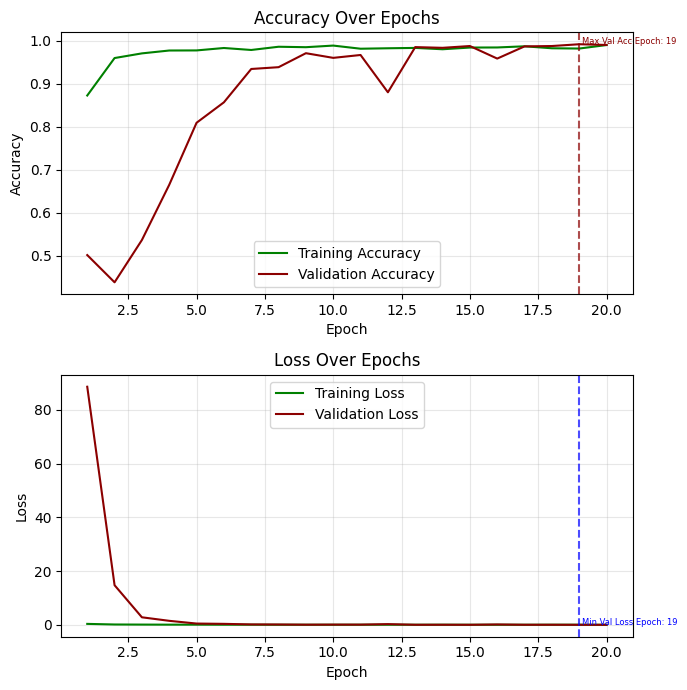

In [48]:
plot_training_history(history_data)